In [39]:
from pyClarion import (Agent, Input, Choice, ChunkStore, FixedRules, 
    Family, Atoms, Atom, IDN, TDError, Train)
from pyClarion.components.stats import MatchStats
from datetime import timedelta
import matplotlib.pyplot as plt

import logging
import sys

import random

logger = logging.getLogger("pyClarion.system")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

## Key Space Definition

In [40]:
class Sound(Atoms):
    target: Atom
    non_target: Atom
    
class IO(Atoms):
    input: Atom
    output: Atom
    goal: Atom
    
class Reward(Atoms):
    correct: Atom
    
class AuditoryData(Family):
    sound: Sound
    io: IO
    reward: Reward

## Model Construction 

In [41]:
p = Family()
h = Family()
d = AuditoryData()
io = d.io
sound = d.sound
reward = d.reward
with Agent("agent", p=p, d=d, h=h) as agent:
    ipt = Input("ipt", (io.input, sound))
    with Choice("choice", p, (io.output, sound)) as choice:
        net = ipt >> IDN("net", # An 'implicit decision network'
            p=p, # Network parameters rperesented by keys of this family          
            h=h, # Hidden nodes represented by keys of this family
            r=reward, # Rewards represented by keys of this sort
            s1=(io.input, sound), # Keyspace for network inputs
            s2=(io.output, sound), # Keyspace for network outputs
            layers=(), # Sequence of layer sizes (empty means single layer mlp)
            train=Train.WEIGHTS,
            gamma=.3, # Discount factor
            lr=1e-2, # Learning rate
        )
        choice.input = net.olayer.main

## Knowledge Initialisation

In [42]:
rewards = [
    {
        "stimulus": + io.input ** sound.target, 
        "reward": {
            ~io.output * ~sound.target:   +1.0, 
            ~io.output * ~sound.non_target: -1.0,
        }
    },
    {
        "stimulus": + io.input ** sound.non_target, 
        "reward": {
            ~io.output * ~sound.target:   -1.0, 
            ~io.output * ~sound.non_target: +1.0,
        }
    },
]

## Event Processing

In [43]:
results = []
reward_vals = []
qvals = []
STOP = 120
N = 100
err, i = float("inf"), 1
while i <= STOP:
    random.shuffle(rewards)
    data = rewards[0]
    ipt.send(data["stimulus"])
    while agent.system.queue:
        event = agent.system.advance()
        if event.source == net.error.update:
            results.append(net.error.main[0].pow(x=2.0))
        if event.source == net.olayer.forward:
            choice.select()
        if event.source == choice.select:
            action = choice.poll()[~io.output * ~sound]
            r = data["reward"][action]
            net.error.send({reward.correct: r})
            reward_vals.append(r)
            qvals.append(choice.input[0].max().c)
    if i % N == 0:
        err = net.error.main.new({}).sum(*results).sum().scale(x=1 / N).c
        print(f"{i} {round(err, 3)}")
        results.clear()
    i += 1

event 0x0000 00:00:00.00 064 0 ipt.send
event 0x0000 00:00:00.00 064 0 ipt.send


event 0x0000 00:00:00.00 064 0 ipt.send
event 0x0000 00:00:00.00 064 0 ipt.send
event 0x0000 00:00:00.00 064 0 ipt.send
event 0x0000 00:00:00.00 064 1 net.update
event 0x0000 00:00:00.00 064 1 net.update
event 0x0000 00:00:00.00 064 1 net.update
event 0x0000 00:00:00.00 064 1 net.update
event 0x0000 00:00:00.00 064 1 net.update
event 0x0000 00:00:00.00 064 2 net.layer.forward
event 0x0000 00:00:00.00 064 2 net.layer.forward
event 0x0000 00:00:00.00 064 2 net.layer.forward
event 0x0000 00:00:00.00 064 2 net.layer.forward
event 0x0000 00:00:00.00 064 2 net.layer.forward
event 0x0000 00:00:00.00 112 3 choice.select
event 0x0000 00:00:00.00 112 3 choice.select
event 0x0000 00:00:00.00 112 3 choice.select
event 0x0000 00:00:00.00 112 3 choice.select
event 0x0000 00:00:00.00 112 3 choice.select
event 0x0000 00:00:00.00 064 4 net.error.update
event 0x0000 00:00:00.00 064 4 net.error.update
event 0x0000 00:00:00.00 064 4 net.error.update
event 0x0000 00:00:00.00 064 4 net.error.update
event 0x

## Change the Rewards

In [44]:
rewards = [
    {
        "stimulus": + io.input ** sound.target, 
        "reward": {
            ~io.output * ~sound.target:   -1.0, 
            ~io.output * ~sound.non_target: +1.0,
        }
    },
    {
        "stimulus": + io.input ** sound.non_target, 
        "reward": {
            ~io.output * ~sound.target:   +1.0, 
            ~io.output * ~sound.non_target: -1.0,
        }
    },
]

## Resume Running the RL Model

In [45]:
while i <= STOP:
    random.shuffle(rewards)
    data = rewards[0]
    ipt.send(data["stimulus"])
    while agent.system.queue:
        event = agent.system.advance()
        if event.source == net.error.update:
            results.append(net.error.main[0].pow(x=2.0))
        if event.source == net.olayer.forward:
            choice.select()
        if event.source == choice.select:
            action = choice.poll()[~io.output * ~sound]
            r = data["reward"][action]
            net.error.send({reward.correct: r})
            reward_vals.append(r)
            qvals.append(choice.input[0].max().c)
    if i % N == 0:
        err = net.error.main.new({}).sum(*results).sum().scale(x=1 / N).c
        print(f"{i} {round(err, 3)}")
        results.clear()
    i += 1

In [46]:
window = N
cumulqvals = []
cumulative = []
for i in range(0, STOP - window):
    cumulqvals.append(sum(qvals[i:i + window])/window)
    cumulative.append(sum(reward_vals[i:i + window])/window)

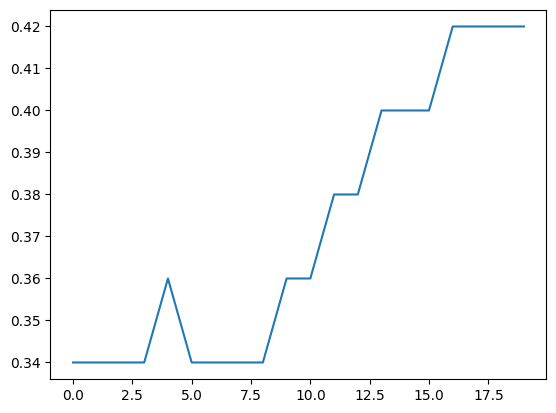

In [47]:
plt.plot(cumulative)
plt.show()

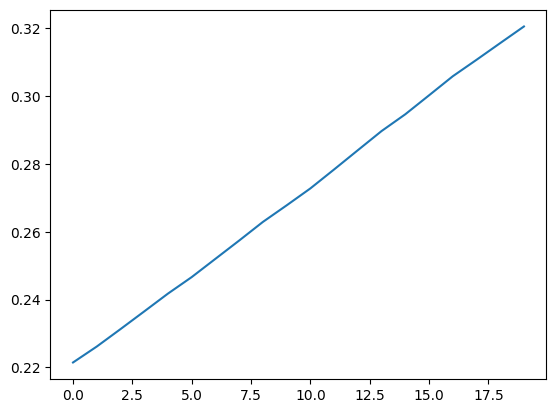

In [48]:
plt.plot(cumulqvals)
plt.show()